# 遗传算法求解无约束优化问题

In [1]:
import numpy as np
import random #种群初始化
import math
import matplotlib.pyplot as plt#绘图

## 优化问题：
\begin{equation}
max \ \ f(x_1,x_2) = 21.5+x_1 \times sin(4 \pi x_1)+x_2 \times sin(20 \pi x_2) \\
s.t. -2.9 \leq x_1 \leq 12.0 \\
 4.2 \leq x_2 \leq 5.7    
\label{eq:optimization_problem}
\end{equation}

## 使用二进制编码
- 精确到小数点后5位
- 计算变量 x1,x2所需要的比特位
\begin{equation}
m_j = \lceil \log_2(b_j-a_j) \times 10^5 \rceil \\
j \in {1,2} \\
此处 b_j是第j个变量可以取到的最大值,a_j为第j个变量可以取到的最小值
\end{equation}

In [2]:
#计算比特位的匿名函数
lenth = lambda bj,aj : math.ceil(math.log2((bj-aj)*10**5))
len1 = lenth(12.0,-2.9)#x1所需要的二进制编码长度
len2 = lenth(5.7,4.2)#x2需要的二进制编码长度

## 遗传算法

In [3]:
class GeneticAgorithm:
    """
        用于求解本例中无约束优化问题的遗传算法结构体
    """
    def __init__(self,len1,len2,pc,pm):
        """
            初始化方法
            
            参数说明:
            -------------------------
            len1 : 变量1的二进制编码长度，该信息用于解码
            len2 : 变量2的二进制编码长度
            pc : probability of crossover 交叉概率
            pm : probability of mutation 变异概率
            -------------------------
            初始化方法将完成种群初始化的任务
        """
        self.len1 = len1
        self.len2 = len2
        self.pc = pc
        self.pm = pm
        #产生初始种群
        self.popsize = 200 #初始种群数量，可修改
        self.population = np.random.randint(0,2,(self.popsize,self.len1+self.len2))
        #产生 popsize * (len1+len2)的0/1随机矩阵，每个行向量代表一个个体
        
        self.a = [-2.9,4.2]#储存优化问题中两个变量的最小值的列表 ,后续用于解码操作
        self.b = [12.0,5.7]#储存优化问题中两个变量的最大值的列表
        
        self.maxiter = 1000#最大迭代次数,可修改
    
    def decode(self,sample):
        """
            为某个个体解码的方法
            将该个体的二进制码解码至实数
            返回值是一个表示点坐标的列表
            -------------------------
            sample 为某个个体的二进制编码向量 type == np.ndarray
        """
        str1,str2 = '','' #初始化两个空字符串
        for i in range(len(sample)):
            #遍历样本向量的每个元素
            if i < self.len1:#当长度在第一个变量长度范围内时，送至str1
                str1 += str(sample[i])
            else:#否则送至str2
                str2 += str(sample[i])
                
        decimal1 = int(str1,2)#二进制转十进制
        decimal2 = int(str2,2)
        #解码
        x1 = self.a[0]+decimal1*(self.b[0]-self.a[0])/(2**self.len1-1) 
        x2 = self.a[1]+decimal2*(self.b[1]-self.a[1])/(2**self.len2-1)
        return [x1,x2] #返回该点坐标列表
    
    def enviroment(self,x):
        """
            环境函数，用于计算解码后的样本x的适应度值
        """
        v = 21.5+x[0]*math.sin(4*math.pi*x[0])+x[1]*math.sin(20*math.pi*x[1])
        return v
        
    def evaluation_for_gene(self,data):
        """
            为给定的种群data评价其适应度，返回其适应度值的列表
            data为二维0/1随机矩阵，代表某一种群，注意矩阵维度匹配
        """
        eval_list = []#评价列表置空
        for i in range(data.shape[0]):
            #遍历种群中所有个体
            x = self.decode(data[i])#解码
            score = self.enviroment(x)#计算适应度
            eval_list.append(score)#加入到列表
        return eval_list
    
    def crossover(self):
        """
            1-断点交叉操作，利用当前结构体中的population生成交叉后的子代children
            返回值是子代的ndarray
        """
        C = []#储存子代的空列表
        for k in range(math.ceil(self.popsize/2)):
            #最多有 种群数量 一半 个对可以交叉产生子代C
            rand = random.random()#随机数
            if self.pc >= rand:
                #当随机数小于等于交叉概率时，进行交叉
                #随机选择两个个体进行交叉
                i = -1#初始化一个选择个体序号的指示器
                j = -1
                while i == j:
                    i = random.randrange(0,self.popsize,1)#产生0~popsize-1的随机整数
                    j = random.randrange(0,self.popsize,1)
                
                #随机选取断点位置
                p = random.randrange(0,self.len1+self.len2,1)
                
                child0 = []#初始化空列表储存子代编码
                child1 = []
                
                #进行交叉
                for m in range(p):
                    child0.append(self.population[i][m])
                    child1.append(self.population[j][m])
                n = p#指示器
                while n<(self.len1+self.len2):
                    child0.append(self.population[j][n])
                    child1.append(self.population[i][n])
                    n += 1
                C.append(child0)#子代添加至列表
                C.append(child1)
        return np.array(C)
    
    def mutation(self):
        """
            单点变异操作
            返回值是变异子代群体的ndarray
        """
        C = []#储存子代的空列表
        for k in range(self.popsize):
            #遍历所有个体
            rand = random.random()#产生0~1之间的随机数
            if self.pm >= rand:#若产生的随机数小于变异概率，进行变异
                #随机选择变异位置
                p = random.randrange(0,self.len1+self.len2,1)
                child = []#子代列表置空
                #进行变异操作
                for i in range(self.len1+self.len2):
                    if i!=p:#不是变异点位时
                        child.append(self.population[k][i])
                    else:#变异位置进行变异
                        child.append(1-self.population[k][i])
                C.append(child)
        return np.array(C)
    
    def update_population_using_crossover_and_mutation(self):
        """
            对种群进行交叉和变异，获取当前进行交叉和变异后的子代以及父代
        """
        C_corssover = self.crossover()#获取当前种群交叉产生的子代
        C_mutation = self.mutation()#获取当前种群变异产生的字代
        if C_corssover.shape[0] != 0:
            #交叉子代非空时，合并矩阵
            self.population = np.concatenate((self.population,C_corssover),axis=0)
        if C_mutation.shape[0] != 0:
            #变异子代非空时，合并矩阵
            self.population = np.concatenate((self.population,C_mutation),axis=0)
        return self.population
    
    def roulette(self):
        """
            轮盘赌对种群进行选择,更新种群
        """
        self.update_population_using_crossover_and_mutation()#交叉变异更新种群
        ##step1 计算群体的总适应度
        eval_list = self.evaluation_for_gene(self.population)
        summation = sum(eval_list)#总适应度
        
        ##step2 计算群体中染色体被选中的概率p

        P = []#储存各个体被选中概率的空列表
        for item in eval_list:
            P.append(item/summation)#概率加入列表
        
        ##step3 计算群体中染色体的累计概率q
        Q = []#累计概率列表
        for i in range(len(P)):#遍历概率列表
            q = 0#累加至这里
            k = 0#计数器
            while k <= i:
                q += P[k]#累加
                k += 1
            Q.append(q)#加入列表
        
        ##step4 随机产生popsize个0~1之间的数
        rand_vector = []#空随机数存储列表
        for i in range(self.popsize):#产生popsize个0~1的随机数
            rand = random.random()
            rand_vector.append(rand)
        
        chosen_index = []#被选择出的个体的下标列表

        for rand_number in rand_vector:#遍历所有随机数
            for i in range(len(Q)):#遍历累计概率列表
                if i == 0 and rand_number <= Q[i]:
                    chosen_index.append(i)
                elif rand_number > Q[i-1] and rand_number <= Q[i]:#比前面的大，比现在的小
                    chosen_index.append(i)
                    
        ##step5 根据chosen_index更新种群矩阵
        CHILDREN = []#子代列表
        for index in chosen_index:#访问选中的下标
            CHILDREN.append(self.population[index])
        
        CHILDREN = np.array(CHILDREN)#list-->ndarray
        
        self.population = CHILDREN#更新种群
        
        return CHILDREN
    
    def start_the_world(self):
        """
            开启世界
        """
        i = 0#迭代指示器
        
        MAX_VALUE = []#存储最大值的列表
        GOODPOINTS = []#存储好点的列表
        
        while i!= self.maxiter:
            self.roulette()#更新种群
            
            #获取评价列表
            current_eval = self.evaluation_for_gene(self.population)
            max_value = max(current_eval)#取最大值
            
            current_eval = np.array(current_eval)#list -->  ndarray
            index = current_eval.argmax()#取最大值对应下标
            #获取当前最佳个体
            current_best_sample = self.population[index]
            points = self.decode(current_best_sample)#解码
            
            MAX_VALUE.append(max_value)
            GOODPOINTS.append(points)
            
            i += 1
        
        max_ = max(MAX_VALUE)#最大值
        Max_value = np.array(MAX_VALUE)#list-->ndarray
        best_index = Max_value.argmax()#取最大值下标
        bestpt = GOODPOINTS[best_index]#最好点
        print(f'运行完毕,最好点为{bestpt},最好值为{max_}')
        
        benchmark={'max_value':MAX_VALUE,'points':GOODPOINTS}
        
        return benchmark#返回一个字典，记录了历史最好记录
    
    def visualization(self):
        result = self.start_the_world()#获取结果
        Max_value = result['max_value']#获取历史最大值信息
        index_list = np.arange(1,self.maxiter+1,1)#迭代次数
        plt.plot(index_list,Max_value)
        plt.grid()
        plt.title('iteration versus funtion value')
        plt.xlabel('generation')
        plt.ylabel('function value')
        plt.show()

## 运行算法

运行完毕,最好点为[11.621700821733867, 5.427950012016343],最好值为38.44668875086933


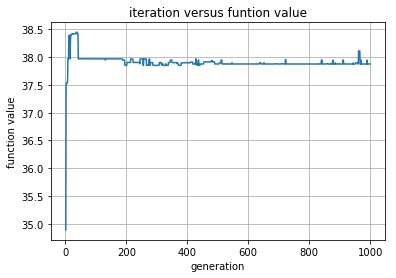

In [5]:
module = GeneticAgorithm(len1,len2,0.25,0.01)
#print(module.evaluation_for_gene(module.population))
module.visualization()